In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib

In [ ]:
import torch
import torchvision

from typing import List
import random
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
# import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision
# from torch.utils.data import DataLoader, random_split
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.5.0


In [ ]:
NUM_CLIENTS = 10

In [ ]:
BATCH_SIZE = 32

def load_datasets(iid):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    if iid:
        # IID: Each client gets an equal portion of all classes
        partition_size = len(trainset) // NUM_CLIENTS
        lengths = [partition_size] * NUM_CLIENTS
        datasets_split = random_split(trainset, lengths)
    else:
        # Non-IID: Each client gets a random subset of classes
        num_classes = 10  # MNIST has 10 classes
        class_indices = [list() for _ in range(num_classes)]

        # Group indices of each class
        for i in range(len(trainset)):
            _, label = trainset[i]
            class_indices[label].append(i)

        datasets_split = []

        # Randomly assign classes to clients
        for _ in range(NUM_CLIENTS):
            selected_classes = random.sample(range(num_classes), k=random.randint(1, num_classes))
            selected_indices = []

            for class_idx in selected_classes:
                selected_indices.extend(class_indices[class_idx])

            client_dataset = Subset(trainset, selected_indices)
            datasets_split.append(client_dataset)


    trainloaders = []
    valloaders = []
    for ds in datasets_split:
        len_val = len(ds) // 10  # 10% validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

# Load IID and non-IID MNIST datasets
iid_trainloaders, iid_valloaders, iid_testloader = load_datasets(iid=True)
non_iid_trainloaders, non_iid_valloaders, non_iid_testloader = load_datasets(iid=False)


In [ ]:
print(len(iid_trainloaders))
print(len(non_iid_trainloaders))

10
10


torch.Size([32, 1, 28, 28])


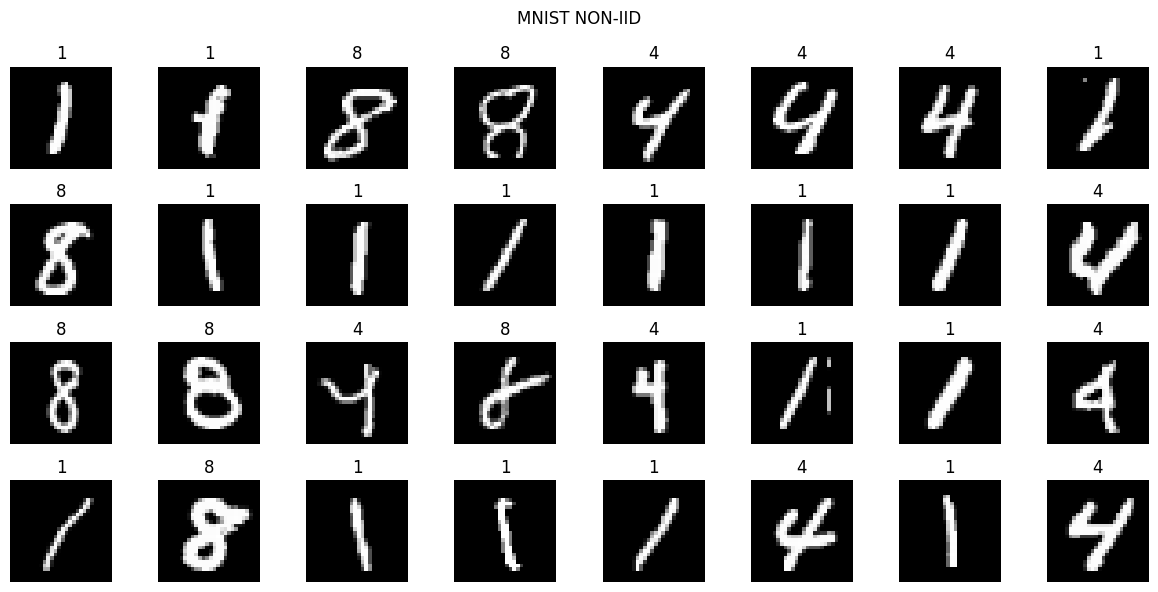

In [ ]:
def display_mnist_images(images, labels, num_rows=4, num_cols=8, title=None):
    images = images.permute(0, 2, 3, 1).numpy()
    images = images / 2 + 0.5

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    fig.suptitle(title)

    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(str(int(labels[i])))
        ax.axis("off")

    fig.tight_layout()
    plt.show()

iid_images, iid_labels = next(iter(iid_trainloaders[0]))
# display_mnist_images(iid_images, iid_labels, title="MNIST IID")

print(iid_images.shape)
# print(iid_images.min(), iid_images.max())

non_iid_images, non_iid_labels = next(iter(non_iid_trainloaders[0]))
display_mnist_images(non_iid_images, non_iid_labels, title="MNIST NON-IID")

# print(non_iid_images.shape)
# print(non_iid_images.min(), non_iid_images.max())

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
def main_training(trainloader, valloader, testloader):
    net = Net().to(DEVICE)

    for epoch in range(5):
        train(net, trainloader[0], 1)
        loss, accuracy = test(net, valloader[0])
        print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

    loss, accuracy = test(net, testloader)
    print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

print('IID')
main_training(iid_trainloaders, iid_valloaders, iid_testloader)
print('NON-IID')
main_training(non_iid_trainloaders, non_iid_valloaders, non_iid_testloader)

IID
Epoch 1: validation loss 0.011676219080885251, accuracy 0.885
Epoch 2: validation loss 0.00785590622574091, accuracy 0.9233333333333333
Epoch 3: validation loss 0.007144927854339281, accuracy 0.925
Epoch 4: validation loss 0.004579620279061298, accuracy 0.9566666666666667
Epoch 5: validation loss 0.0038711626160268984, accuracy 0.9616666666666667
Final test set performance:
	loss 0.0036450711994839365
	accuracy 0.9625
NON-IID
Epoch 1: validation loss 0.001914330104131472, accuracy 0.9831795984807379
Epoch 2: validation loss 0.0008024423366058284, accuracy 0.9896907216494846
Epoch 3: validation loss 0.000781712049399303, accuracy 0.9913185024416712
Epoch 4: validation loss 0.0013946776666283827, accuracy 0.9837221920781335
Epoch 5: validation loss 0.0011728646223918685, accuracy 0.9880629408572978
Final test set performance:
	loss 0.8601150875091552
	accuracy 0.3075


**FL**

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    # Returns the parameters of the model as a list of numpy arrays
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    # Updates the given net with the given parameters
    # (retruns nothing as it will just modify the net object)
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        # Return the current local parameters
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Train the local model after updating it with the given parameters
        # Return the parameters from the newly trained model, the length
        # of the training data, and a dict (empty in this case)
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        # Perform the evaluation of the model after updating it with the given
        # parameters. Returns the loss as a float, the length of the validation
        # data, and a dict containing the accuracy
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(cid: str, iid) -> FlowerClient:
    """Create a Flower client for MNIST dataset, representing a single organization."""

    # Create model
    net = Net().to(DEVICE)

    # Load data (MNIST)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    if iid:
        # For IID
        trainloader = iid_trainloaders[int(cid)]
        valloader = iid_valloaders[int(cid)]
    else:
        # For non-IID
        trainloader = non_iid_trainloaders[int(cid)]
        valloader = non_iid_valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=5),
#     strategy=strategy,
#     client_resources=client_resources,
# )


# # Start simulation for MNIST non-IID scenario
# fl.simulation.start_simulation(
#     client_fn=lambda cid: client_fn(cid, iid=False),
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=5),
#     strategy=strategy,
#     client_resources=client_resources,
# )

In [ ]:
# fl.simulation.start_simulation(
#     client_fn=lambda cid: client_fn(cid, iid=True),
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=5),
#     strategy=strategy,
#     client_resources=client_resources,
# )

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=3),
#     strategy=strategy,
#     client_resources=client_resources,
# )

fl.simulation.start_simulation(
    client_fn=lambda cid: client_fn(cid, iid=True),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-23 19:52:30,318 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-09-23 19:52:33,258	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-23 19:52:36,332 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 7779183822.0, 'object_store_memory': 3889591910.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 7779183822.0, 'object_store_memory': 3889591910.0}
INFO flwr 2023-09-23 19:52:36,339 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-23 19:52:36,345 | app.py:224 | Flower VCE: Resources for each Virtual Clie

History (loss, distributed):
	round 1: 0.01493615671992302
	round 2: 0.0056300058756023645
	round 3: 0.0036506853966663286
	round 4: 0.0032124788134048382
	round 5: 0.0026131247978967926
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.8803333333333333), (2, 0.9413333333333335), (3, 0.963), (4, 0.9660000000000001), (5, 0.9716666666666667)]}

In [ ]:
fl.simulation.start_simulation(
    client_fn=lambda cid: client_fn(cid, iid=False),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-23 19:54:37,549 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-09-23 19:54:42,428	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-23 19:54:44,262 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3889392844.0, 'memory': 7778785691.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3889392844.0, 'memory': 7778785691.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-09-23 19:54:44,269 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-23 19:54:44,273 | app.py:224 | Flower VCE: Resources for each Virtual Clie

History (loss, distributed):
	round 1: 0.01609529341506889
	round 2: 0.002199959180788933
	round 3: 0.0013819218788557264
	round 4: 0.0007390365079196756
	round 5: 0.0007485118808426116
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.8553922753768193), (2, 0.9794863920260639), (3, 0.9871675213079797), (4, 0.9933186759071408), (5, 0.9930772459879907)]}